In [1]:
import json
import os
import pickle
from collections import defaultdict
from datetime import datetime

import numpy as np
import seaborn as sns
from datasets import load_dataset
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

sns.set()
%matplotlib inline

/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pile = load_dataset('usvsnsp/pile-semantic-memorization-filter-results')
memorized = load_dataset('usvsnsp/memories-semantic-memorization-filter-results')

In [4]:
pile.keys()

dict_keys(['pile.deduped.1.4b', 'pile.deduped.12b', 'pile.deduped.160m', 'pile.deduped.1b', 'pile.deduped.2.8b', 'pile.deduped.410m', 'pile.deduped.6.9b', 'pile.deduped.70m', 'pile.duped.1.4b', 'pile.duped.12b', 'pile.duped.160m', 'pile.duped.1b', 'pile.duped.2.8b', 'pile.duped.410m', 'pile.duped.6.9b', 'pile.duped.70m'])

In [5]:
memorized.keys()

dict_keys(['memories.deduped.1.4b', 'memories.deduped.12b', 'memories.deduped.160m', 'memories.deduped.1b', 'memories.deduped.2.8b', 'memories.deduped.410m', 'memories.deduped.6.9b', 'memories.deduped.70m', 'memories.duped.1.4b', 'memories.duped.12b', 'memories.duped.160m', 'memories.duped.1b', 'memories.duped.2.8b', 'memories.duped.410m', 'memories.duped.6.9b', 'memories.duped.70m'])

## Linear Model Training

In [6]:
feature_columns = [
    'max_frequency',
    'avg_frequency',
    'min_frequency',
    'median_frequency',
    'p25_frequency',
    'p75_frequency',
    'prompt_perplexity',
    'generation_perplexity',
    'sequence_perplexity',
]
scaled_feature_columns = [
    'max_frequency',
    'avg_frequency',
    'min_frequency',
    'median_frequency',
    'p25_frequency',
    'p75_frequency',
    'prompt_perplexity',
    'generation_perplexity',
    'sequence_perplexity',
]

In [7]:
# Data Hyper-parameters
seed = 2023_09_22
validation_split_percentage = 0.2

# Model Hyper-parameters
max_model_iterations = 1000
fit_intercept = False
reg_name = 'l2'
# Inverse of regularization strength; smaller values specify stronger regularization.
# Reference https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
reg_strength = 1.0

data_sources = [
    ('memorized', memorized),
    # Comment this out for quick iterations, uncomment this to run it on the pile datasets
    # ('pile', pile),
]
label_metadata = [
    # taxonomy, column, metadata_kwargs
    ('recitation', 'sequence_duplicates', {'threshold': 200})
]
outputs = defaultdict(dict)

In [8]:
for source_name, source in data_sources:
    for model_name in source.keys():
        tokens = model_name.split('.', 2)
        data_type, data_scheme, model_size = tokens[0], tokens[1], tokens[2]
        raw_df = source[model_name].to_pandas()
        
        # Remove invalid rows where perplexities < 0 or perplexities = inf
        filtered_df = raw_df[
            (raw_df.prompt_perplexity != -1) &
            (raw_df.generation_perplexity != -1) &
            (raw_df.sequence_perplexity != -1) &
            (raw_df.prompt_perplexity != np.inf) &
            (raw_df.generation_perplexity != np.inf) &
            (raw_df.sequence_perplexity != np.inf)
        ]

        # Filter down to features needed for linear modeling
        features = filtered_df[feature_columns]

        for column in scaled_feature_columns:
            # Natural log the frequency columns for feature scaling
            features[column] = np.log1p(features[column])
        
        print(f'Running on {model_name}...')
        print('=' * 15)

        for taxonomy, label_column, metadata in label_metadata:
            print(f'Training logistic regression model with label column of {label_column}...')
            print('=' * 30)
            
            # We'll bucketize specific columns into labels to train binary logistic classifiers
            if label_column == 'sequence_duplicates':
                recitation_threshold = metadata['threshold']
                labels = (filtered_df[column] > recitation_threshold).astype(int)
            
            negatives = labels.value_counts().iloc[0] / len(labels)
            positives = labels.value_counts().iloc[1] / len(labels)
            print(f'Prior for {label_column} under taxonomy {taxonomy}')
            print(f'Positives: {positives * 100:.4f}% Negatives: {negatives * 100:.4f}%')

            # Split the dataset into 80% training and 20% validation
            X_train, X_val, Y_train, Y_val = train_test_split(features, labels, test_size=validation_split_percentage, random_state=seed)

            # Train the model on the training data
            model = LogisticRegression(fit_intercept=fit_intercept, random_state=seed, max_iter=max_model_iterations, penalty=reg_name, C=reg_strength)
            model.fit(X_train, Y_train)

            # Predict on the validation data
            Y_hat_val = model.predict_proba(X_val)[:, 1]

            # Calculate classification metrics
            roc_auc = roc_auc_score(Y_val, Y_hat_val)
            pr_auc = average_precision_score(Y_val, Y_hat_val)
            print(f'ROC AUC: {roc_auc:.4f} PR AUC: {pr_auc:.4}')
            print(f'Coefficients: {model.coef_}')
            print('=' * 30)
            print('\n' * 2)

            # Saving the model for visualizations
            if taxonomy not in outputs[source_name]:
                outputs[source_name][taxonomy] = defaultdict(list)
            outputs[source_name][taxonomy][label_column].append((data_type, data_scheme, model_size, model, roc_auc, pr_auc))

/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.1.4b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0019% Negatives: 99.9981%
ROC AUC: 1.0000 PR AUC: 0.9762
Coefficients: [[-0.16163421 -0.4492729  -0.54027395  0.20001609 -0.01655083 -0.2746598
   1.23710618  1.07075264  2.62531507]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.12b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0014% Negatives: 99.9986%
ROC AUC: 1.0000 PR AUC: 1.0
Coefficients: [[ 0.70861526 -0.90817098 -0.21294854 -0.2619331   0.16986806 -0.66894416
   0.18942412  1.95603132  2.65260709]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.160m...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0938% Negatives: 99.9062%
ROC AUC: 1.0000 PR AUC: 0.9932
Coefficients: [[ 0.41602399 -0.67214244 -0.89817118  0.49739202 -0.24372812 -0.42525921
  -0.35474472 -1.18086514  4.21938578]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.1b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0025% Negatives: 99.9975%
ROC AUC: 1.0000 PR AUC: 0.9617
Coefficients: [[-0.11399918 -0.4214687  -0.72731296  1.00985058 -0.81870252 -0.27350628
   1.00080329  1.13524904  2.87928512]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.2.8b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0038% Negatives: 99.9962%
ROC AUC: 1.0000 PR AUC: 0.9936
Coefficients: [[-0.43275775 -0.64842664 -1.14239258  0.29946056  0.24486035  0.1928635
   0.97216152  1.5839751   3.19782529]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.410m...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0043% Negatives: 99.9957%
ROC AUC: 1.0000 PR AUC: 0.9422
Coefficients: [[ 0.2371954  -0.63705312 -0.75068358 -0.07863626  0.15537122 -0.32438221
   1.04593341  1.23777149  2.78035378]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.6.9b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0016% Negatives: 99.9984%
ROC AUC: 1.0000 PR AUC: 1.0
Coefficients: [[ 0.0060403  -0.26130508 -0.88528238  0.09465295 -0.32505935 -0.13841345
   0.88593893  1.73122774  3.00441053]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.70m...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0355% Negatives: 99.9645%
ROC AUC: 1.0000 PR AUC: 0.9402
Coefficients: [[ 0.52968396 -1.40332074 -0.8014931   1.37327666 -0.62793821 -0.60101403
   0.79464392  1.69054864  3.26307064]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.1.4b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0043% Negatives: 99.9957%
ROC AUC: 1.0000 PR AUC: 0.9924
Coefficients: [[ 0.46339619 -0.92011087 -1.15472392  0.19713765 -0.38042003  0.02851259
   1.15847932  1.78087497  3.28113966]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.12b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0008% Negatives: 99.9992%
ROC AUC: 1.0000 PR AUC: 0.8333
Coefficients: [[ 0.00538252 -0.27707027 -0.41626854  0.43343839 -0.44136143 -0.59758393
   1.19155752  1.21441304  2.68239489]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.160m...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0523% Negatives: 99.9477%
ROC AUC: 1.0000 PR AUC: 0.998
Coefficients: [[ 0.09259068 -0.71847951 -1.10553086 -0.18038897  0.01252293 -0.05992848
   1.14323743  1.45499783  4.48594568]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.1b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0028% Negatives: 99.9972%
ROC AUC: 1.0000 PR AUC: 1.0
Coefficients: [[-0.19000602 -0.45709177 -1.04354675  0.2979668  -0.16352088  0.0905297
   0.99872519  1.64925872  2.92301349]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.2.8b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0017% Negatives: 99.9983%
ROC AUC: 1.0000 PR AUC: 1.0
Coefficients: [[ 0.24715885 -0.66554467 -0.44518461 -0.16196184 -0.08196172 -0.31331036
   1.0274678   1.68918769  3.02778115]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.410m...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0060% Negatives: 99.9940%
ROC AUC: 1.0000 PR AUC: 0.9952
Coefficients: [[ 0.16165333 -0.745935   -0.90001017 -0.30862979  0.26662873  0.10697081
   1.01157284  1.37159317  2.85138328]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.6.9b...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0006% Negatives: 99.9994%
ROC AUC: 1.0000 PR AUC: 1.0
Coefficients: [[-0.20014285 -0.3371293  -0.63335571  0.62879242 -0.73423704 -0.02232073
   0.88714425  1.284409    2.51417426]]





/tmp/ipykernel_271355/645748431.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.70m...
Training logistic regression model with label column of sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0248% Negatives: 99.9752%
ROC AUC: 1.0000 PR AUC: 1.0
Coefficients: [[ 0.34952215 -0.43113445 -0.28168876 -0.64997239 -0.03256076 -0.25467012
  -0.47428354  0.9055002   3.76170838]]





## Saving Model Artifacts

In [9]:
base_directory = 'artifacts'
run_id = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = 'model.pkl'
metadata_name = 'metadata.json'

for source_name in outputs:
    for taxonomy in outputs[source_name]:
        for label_column in outputs[source_name][taxonomy]:
            for data_type, data_scheme, model_size, model, roc_auc, pr_auc in tqdm(outputs[source_name][taxonomy][label_column]):
                full_directory = f'{base_directory}/{run_id}/{data_type}/{data_scheme}/{model_size}/{taxonomy}/{label_column}'

                if not os.path.exists(full_directory):
                    os.makedirs(full_directory)

                model_path = os.path.join(full_directory, model_name)
                with open(model_path, 'wb') as file:
                    pickle.dump(model, file)

                metadata = {
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'data_type': data_type,
                    'data_scheme': data_scheme,
                    'model_size': model_size,
                    'taxonomy': taxonomy,
                    'label_column': label_column,
                }

                metadata_path = os.path.join(full_directory, metadata_name)
                with open(metadata_path, 'w') as file:
                    json.dump(metadata, file)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2303.38it/s]


## Linear Model Visualizations

### Coefficients Heatmap

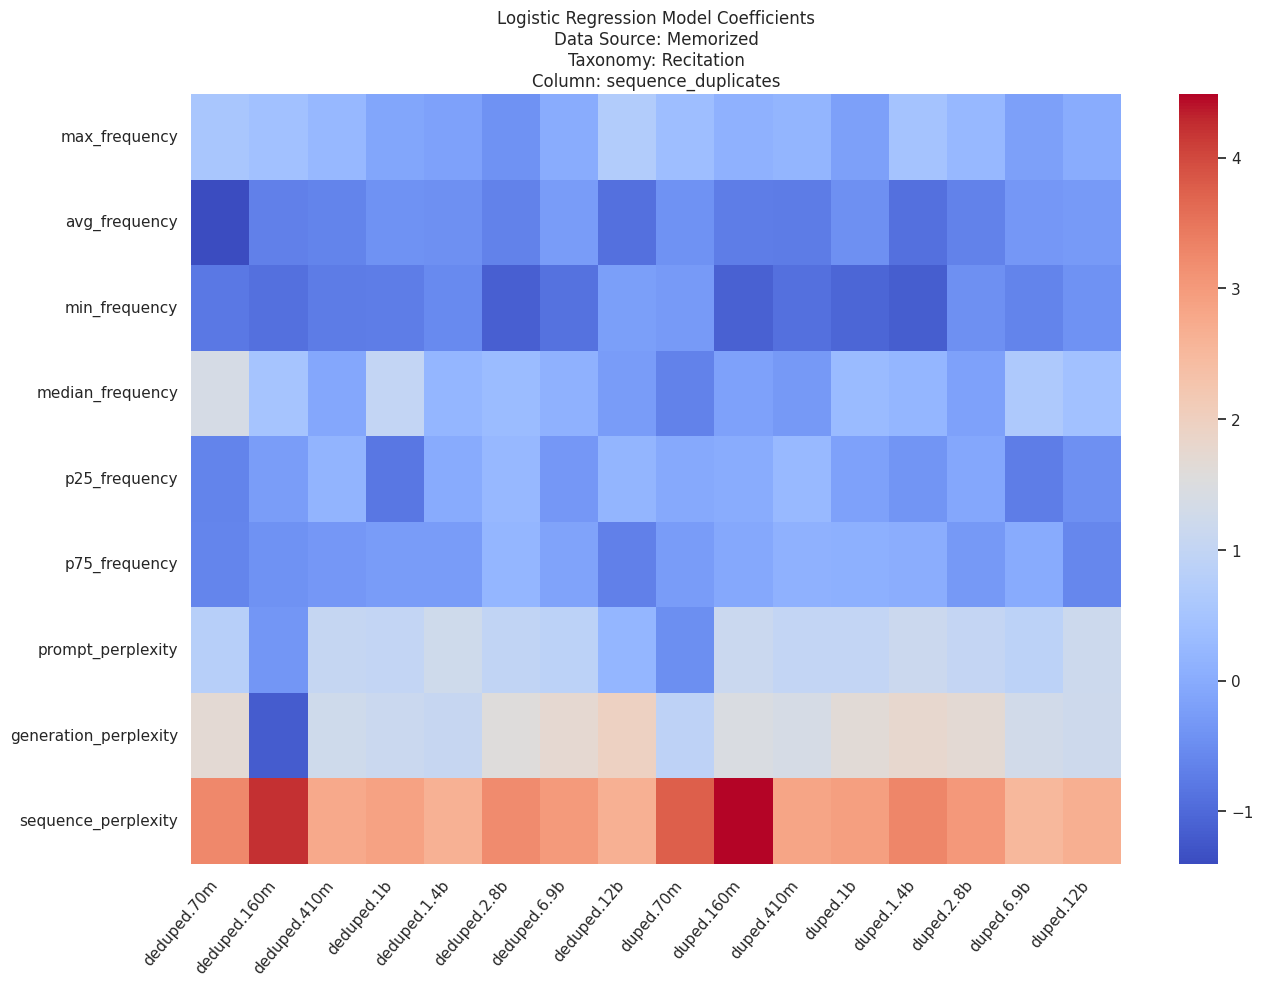

In [10]:
parameter_count_ordering = {
    '70m': 0,
    '160m': 1,
    '410m': 2,
    '1b': 3,
    '1.4b': 4,
    '2.8b': 5,
    '6.9b': 6,
    '12b': 7,
}

for source_name in outputs:
    for taxonomy in outputs[source_name]:
        for label_column in outputs[source_name][taxonomy]:
            coefficients = {}
            # Sort the display order by the model parameter counts
            ordered_by_params = sorted(outputs[source_name][taxonomy][label_column], key=lambda x: (x[1], parameter_count_ordering[x[2]]))
            
            for data_type, data_scheme, model_size, model, _, _ in ordered_by_params:
                model_name = f'{data_scheme}.{model_size}'
                coefficients[model_name] = model.coef_[0]
            
            coefficient_data = np.array(list(coefficients.values())).T

            plt.figure(figsize=(15, 10))
            sns.heatmap(coefficient_data, annot=False, cmap='coolwarm', cbar=True, xticklabels=coefficients.keys(), yticklabels=feature_columns)
            plt.setp(plt.gca().get_xticklabels(), rotation=50, horizontalalignment='right')

            plt.title(f'Logistic Regression Model Coefficients\nData Source: {source_name.capitalize()}\nTaxonomy: {taxonomy.capitalize()}\nColumn: {label_column}')
            plt.show()

## Conditional Tests

In [11]:
# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
from scipy.stats import pearsonr as pearson_correlation

# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
from scipy.stats import spearmanr as spearman_correlation

# Paper - https://arxiv.org/abs/1909.10140
# API - https://swarnakumar.github.io/xicorpy/xi/
from xicorpy import compute_xi_correlation as xi_correlation

In [12]:
conditional_test_outputs = defaultdict(dict)
"""
Feature pre-processing code is the same.
TODO: Unify them together as separate code blocks
"""
pass

In [21]:
for source_name, source in data_sources:
    for model_name in source.keys():
        tokens = model_name.split('.', 2)
        data_type, data_scheme, model_size = tokens[0], tokens[1], tokens[2]
        raw_df = source[model_name].to_pandas()
        
        # Remove invalid rows where perplexities < 0 or perplexities = inf
        filtered_df = raw_df[
            (raw_df.prompt_perplexity != -1) &
            (raw_df.generation_perplexity != -1) &
            (raw_df.sequence_perplexity != -1) &
            (raw_df.prompt_perplexity != np.inf) &
            (raw_df.generation_perplexity != np.inf) &
            (raw_df.sequence_perplexity != np.inf)
        ]

        # Filter down to features needed for linear modeling
        features = filtered_df[feature_columns]

        for column in scaled_feature_columns:
            # Natural log the frequency columns for feature scaling
            features[column] = np.log1p(features[column])
        
        print(f'Running on {model_name}...')
        print('=' * 15)

        for taxonomy, label_column, metadata in label_metadata:
            print(f'Calculating conditional tests with {label_column}...')
            print('=' * 30)
            
            # We'll bucketize specific columns into labels to train binary logistic classifiers
            if label_column == 'sequence_duplicates':
                recitation_threshold = metadata['threshold']
                labels = (filtered_df[column] > recitation_threshold).astype(int)
            
            negatives = labels.value_counts().iloc[0] / len(labels)
            positives = labels.value_counts().iloc[1] / len(labels)
            print(f'Prior for {label_column} under taxonomy {taxonomy}')
            print(f'Positives: {positives * 100:.4f}% Negatives: {negatives * 100:.4f}%')
            
            pearsons = []
            spearmans = []
            xis = []
            
            for i in range(len(feature_columns)):
                pearson = pearson_correlation(x=features.iloc[:, i], y=labels)
                spearman = spearman_correlation(a=features.iloc[:, i], b=labels)
                xi = xi_correlation(x=features.iloc[:, i], y=labels, get_p_values=True, get_modified_xi=False)
                pearsons.append(pearson)
                spearmans.append(spearman)
                # (correlation, p-value)
                xis.append((xi[0].iloc[0].iloc[0], xi[1].iloc[0].iloc[0]))
            
            print('=' * 30)
            print('\n' * 2)

            # Saving the model for visualizations
            if taxonomy not in conditional_test_outputs[source_name]:
                conditional_test_outputs[source_name][taxonomy] = defaultdict(list)
            conditional_test_outputs[source_name][taxonomy][label_column].append((data_type, data_scheme, model_size, pearsons, spearmans, xis))

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.1.4b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0019% Negatives: 99.9981%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9996184738739294' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9996375501802329' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.12b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0014% Negatives: 99.9986%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9996388578274461' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9996666379945656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9996527479110058' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi


/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.160m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0938% Negatives: 99.9062%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6805146721487104' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6935675746484713' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.1b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0025% Negatives: 99.9975%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9993710405699341' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9993961989471367' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.2.8b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0038% Negatives: 99.9962%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9981217875744556' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9984598658110536' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9982720445684992' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/hom

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.410m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0043% Negatives: 99.9957%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9985778628408668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9987071480371517' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.6.9b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0016% Negatives: 99.9984%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9995663122773459' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9996144998020853' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9995823747855924' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/hom

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.deduped.70m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0355% Negatives: 99.9645%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9523943363022871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9571211397900032' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.1.4b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0043% Negatives: 99.9957%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9975149792135957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9977720503294306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.12b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0008% Negatives: 99.9992%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9998791244073159' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9998640149582304' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.160m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0523% Negatives: 99.9477%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8532502697448532' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8541316495061454' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8688947605077892' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/hom

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.1b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0028% Negatives: 99.9972%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:343: RuntimeWarning: invalid value encountered in sqrt
  p = 1 - ss.norm.cdf(np.sqrt(n) * xi / np.sqrt(v))
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:344: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(v), p
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.999109175312171' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9990813370406764' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.2.8b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0017% Negatives: 99.9983%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9994981579192571' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.999515462818593' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9995327677179291' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi


/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.410m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0060% Negatives: 99.9940%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9970808012215452' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9974978296184673' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9969020747657215' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/hom

/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.6.9b...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0006% Negatives: 99.9994%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9999321105372244' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9999377679924557' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi


/tmp/ipykernel_271355/3881734386.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[column] = np.log1p(features[column])


Running on memories.duped.70m...
Calculating conditional tests with sequence_duplicates...
Prior for sequence_duplicates under taxonomy recitation
Positives: 0.0248% Negatives: 99.9752%


/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9739573929659808' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9746807987169258' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/home/mchorse/lib/miniconda3/lib/python3.11/site-packages/xicorpy/correlation.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9735956900905084' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ret.loc[i, j] = xi
/hom

## Conditional Test Visualizations

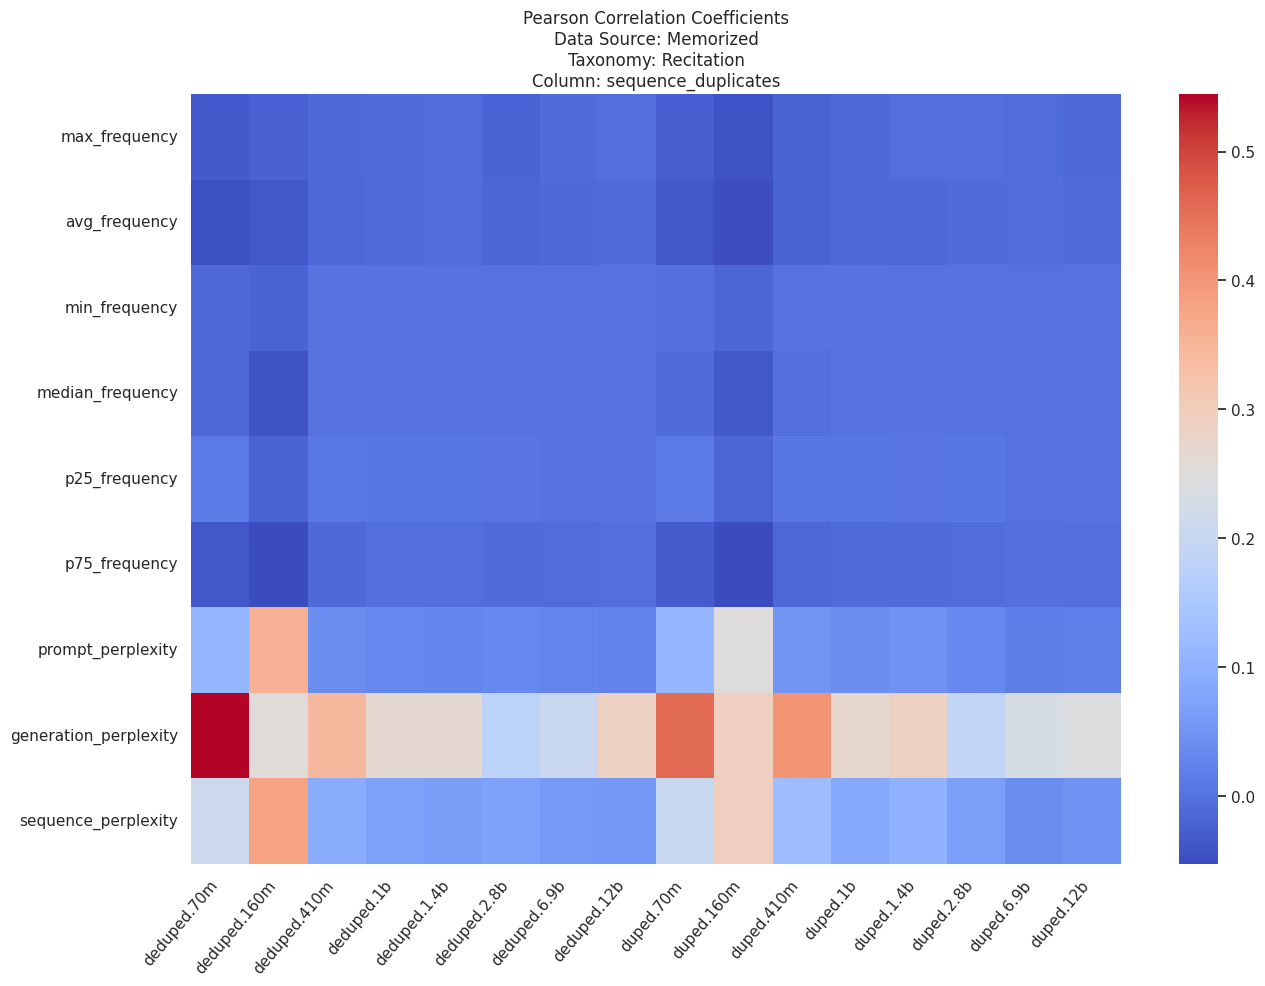

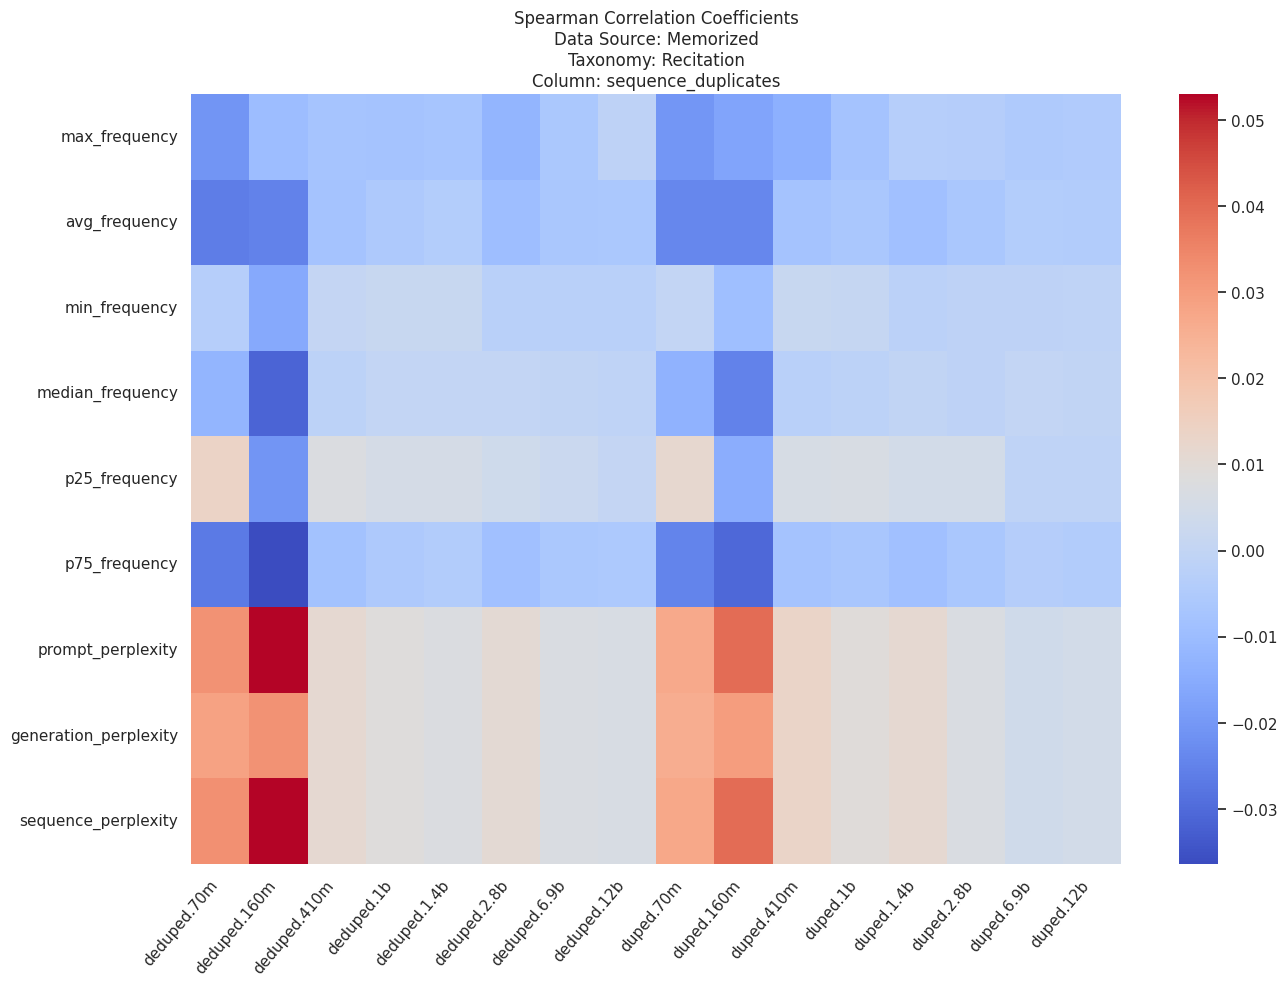

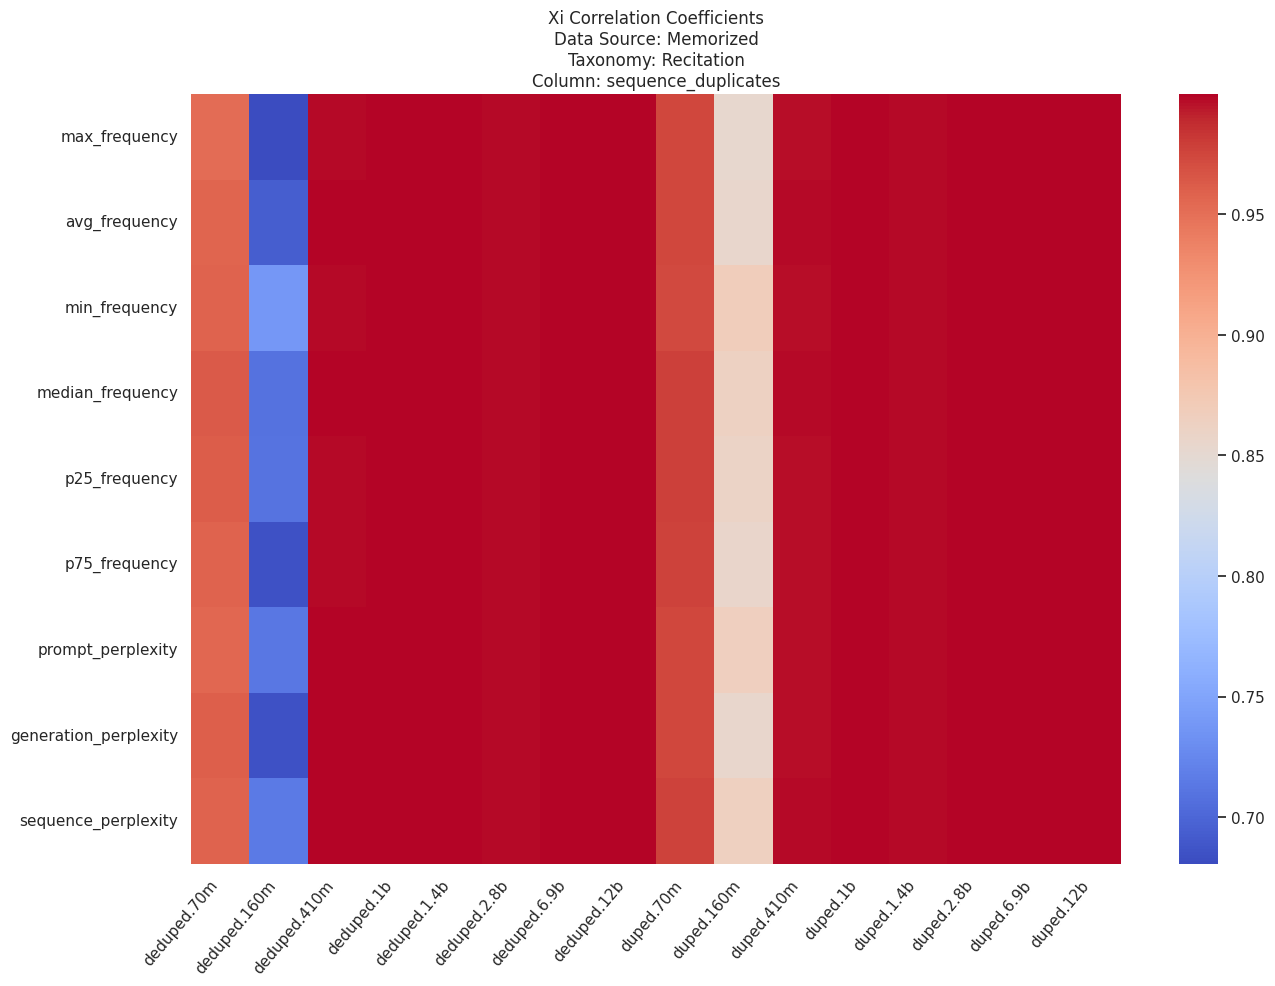

In [36]:
for source_name in conditional_test_outputs:
    for taxonomy in conditional_test_outputs[source_name]:
        for label_column in conditional_test_outputs[source_name][taxonomy]:
            pearson_coefficients = {}
            spearman_coefficients = {}
            xi_coefficients = {}
            # Sort the display order by the model parameter counts
            ordered_by_params = sorted(conditional_test_outputs[source_name][taxonomy][label_column], key=lambda x: (x[1], parameter_count_ordering[x[2]]))
            
            for data_type, data_scheme, model_size, pearsons, spearmans, xis in ordered_by_params:
                model_name = f'{data_scheme}.{model_size}'
                pearson_correlations = [p.correlation for p in pearsons]
                spearman_correlations = [s.correlation for s in spearmans]
                xi_correlations = [x[0] for x in xis]
                pearson_coefficients[model_name] = pearson_correlations
                spearman_coefficients[model_name] = spearman_correlations
                xi_coefficients[model_name] = xi_correlations
            
            # Pearson
            plt.figure(figsize=(15, 10))
            sns.heatmap(np.array(list(pearson_coefficients.values())).T, annot=False, cmap='coolwarm', cbar=True, xticklabels=pearson_coefficients.keys(), yticklabels=feature_columns)
            plt.setp(plt.gca().get_xticklabels(), rotation=50, horizontalalignment='right')
            plt.title(f'Pearson Correlation Coefficients\nData Source: {source_name.capitalize()}\nTaxonomy: {taxonomy.capitalize()}\nColumn: {label_column}')
            plt.show()
            
            # Spearman
            plt.figure(figsize=(15, 10))
            sns.heatmap(np.array(list(spearman_coefficients.values())).T, annot=False, cmap='coolwarm', cbar=True, xticklabels=spearman_coefficients.keys(), yticklabels=feature_columns)
            plt.setp(plt.gca().get_xticklabels(), rotation=50, horizontalalignment='right')
            plt.title(f'Spearman Correlation Coefficients\nData Source: {source_name.capitalize()}\nTaxonomy: {taxonomy.capitalize()}\nColumn: {label_column}')
            plt.show()
            
            # Xi
            plt.figure(figsize=(15, 10))
            sns.heatmap(np.array(list(xi_coefficients.values())).T, annot=False, cmap='coolwarm', cbar=True, xticklabels=xi_coefficients.keys(), yticklabels=feature_columns)
            plt.setp(plt.gca().get_xticklabels(), rotation=50, horizontalalignment='right')
            plt.title(f'Xi Correlation Coefficients\nData Source: {source_name.capitalize()}\nTaxonomy: {taxonomy.capitalize()}\nColumn: {label_column}')
            plt.show()